# Exploratory Data Analysis

## Proposal Amendment

Before diving into the Exploratory Data Analysis, I'd like to make an amendment to my proposal, slightly altering and then narrowing down the details of my project.

### Questions
- Stellar Flares Question: *Can we estimate the energy emitted by a flare?*
- My Question: *Can we identify whether a given point on a PDCSAP time series is a part of a flare?*

### Methods
- **Pre-treatment:** Detrending

- **Model:** 

- **Model evaluation:** Flare simulation
Simulating flares in a real PDCSAP time series will provide a controlled setting with which the model can be evaluated. Varying the parameters of the simulated flares will further allow for estimation of the model sensitivity, especially valuable to observe with respect to flare intensity.


Ideas:
- ARIMA model - with detrending included
    - STL with loess
- ML model - Unsupervised - Isolation tree, KNN
    - With cross validation
- ML model - Supervised - Simulate flares --> traing XGboost on simulated flares, run on real data...?
    - Not guaranteed to work well on real data though - could compare against other models...

- Create a plot, where each observation is coloured as a gradient of how likely it is part of a flare.
    - Then, can create a plot where observations classified as flares are highlighted, with sort of "credible intervals" placed on them, including all adjacent observations with higher probabilities.

## Exploratory Data Analysis

For this project, we will focus on the M dwarf TIC 031381302, as done with the related paper. The date ranges analyzed in the paper are different, but this will give us a benchmark for our model.

To get familiar with the data, we will load it using pandas library, get a distribution of values, take a look at the time series as a whole, and then start looking at patterns in the data.

In [192]:
## Libraries
# lightkurve
#import lightkurve as lk
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import random

In [193]:
## Data
df = pd.read_csv("031381302.csv")

# Check
print(df.shape)
#df.head()
#random.seed(2453)
#df.loc[random.sample(range(df.shape[0]), 1) + np.arange(0, 5)]
df.info()

(17719, 24)
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 17719 entries, 0 to 17718
Data columns (total 24 columns):
 #   Column           Non-Null Count  Dtype  
---  ------           --------------  -----  
 0   time             17719 non-null  float64
 1   flux             17033 non-null  float64
 2   flux_err         17033 non-null  float64
 3   timecorr         17719 non-null  float64
 4   cadenceno        17719 non-null  int64  
 5   centroid_col     17649 non-null  float64
 6   centroid_row     17649 non-null  float64
 7   sap_flux         17649 non-null  float64
 8   sap_flux_err     17649 non-null  float64
 9   sap_bkg          17649 non-null  float64
 10  sap_bkg_err      17649 non-null  float64
 11  pdcsap_flux      17033 non-null  float64
 12  pdcsap_flux_err  17033 non-null  float64
 13  quality          17719 non-null  int64  
 14  psf_centr1       0 non-null      float64
 15  psf_centr1_err   0 non-null      float64
 16  psf_centr2       0 non-null      float64
 17  

In [194]:
## Time Series of interest
pdcsap = df.loc[:, ["time", "pdcsap_flux"]]

# Check
print(pdcsap.shape); pdcsap.info(); pdcsap.head()

(17719, 2)
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 17719 entries, 0 to 17718
Data columns (total 2 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   time         17719 non-null  float64
 1   pdcsap_flux  17033 non-null  float64
dtypes: float64(2)
memory usage: 277.0 KB


,time,pdcsap_flux
0,1437.978646,NaN
1,1437.980034,NaN
2,1437.981423,NaN
3,1437.982812,NaN
4,1437.984201,NaN


In [195]:
## NaNs/Nulls
nulls = pdcsap.isnull().sum()
print(nulls)
#print([nulls, pdcsap.shape[0]*pdcsap.shape[1] - nulls])
# Time
#nans = pdcsap["time"].isna().sum()
print([nulls[0], pdcsap.shape[0] - nulls[0]])
# PDCSAP flux
#nans = pdcsap["pdcsap_flux"].isna().sum()
print([nulls[1], pdcsap.shape[0] - nulls[1]])

# Impute missing values (temporary)
# pdcsap_mod: Modified pdcsap_flux by imputing them with the mean (temporary).
pdcsap["pdcsap_mod"] = pdcsap["pdcsap_flux"]
pdcsap.fillna(pdcsap["pdcsap_mod"].mean(), inplace=True)

time             0
pdcsap_flux    686
dtype: int64
[0, 17719]
[686, 17033]


### Comments

Thankfully, there are no missing time values, but there seem to be nearly 700 missing flux values. During pre-treatment, we will need to explore whether we can avoid imputing them. If imputation is needed, we could utilize a trend-based forecast, perhaps an ARIMA model.

In [196]:
## Set "time" as index
pdcsap.set_index("time", inplace=True)

# Check
print(pdcsap.shape); pdcsap.info(); pdcsap.head()

(17719, 2)
<class 'pandas.core.frame.DataFrame'>
Float64Index: 17719 entries, 1437.978645522663 to 1464.2854684532865
Data columns (total 2 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   pdcsap_flux  17719 non-null  float64
 1   pdcsap_mod   17719 non-null  float64
dtypes: float64(2)
memory usage: 415.3 KB


,pdcsap_flux,pdcsap_mod
time,,
1437.978646,1564.459684,1564.459684
1437.980034,1564.459684,1564.459684
1437.981423,1564.459684,1564.459684
1437.982812,1564.459684,1564.459684
1437.984201,1564.459684,1564.459684


## Distribution

        pdcsap_flux    pdcsap_mod
count  17719.000000  17719.000000
mean    1564.459684   1564.459684
std        9.134393      9.134393
min     1530.508200   1530.508200
25%     1558.443950   1558.443950
50%     1564.459684   1564.459684
75%     1570.340550   1570.340550
max     1679.386400   1679.386400


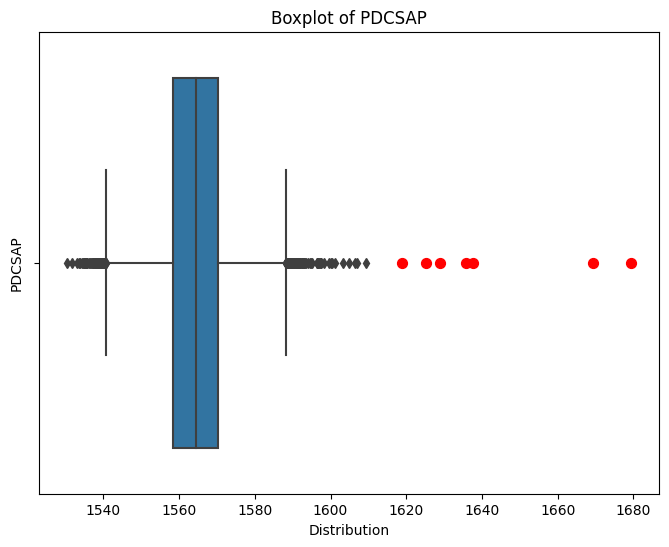

In [197]:
## Distribution
# Summary statistics
print(pdcsap.describe())

# Boxplot
plt.figure(figsize=(8, 6))
#pdcsap.boxplot(pdcsap)
sns.boxplot(x = pdcsap["pdcsap_flux"])
plt.title("Boxplot of PDCSAP")
plt.ylabel("PDCSAP")
plt.xlabel("Distribution")

# Flag outliers
mean_val = pdcsap["pdcsap_flux"].mean()
std_val = pdcsap["pdcsap_flux"].std()
num_devs = 5
outliers = (pdcsap["pdcsap_flux"] < mean_val - num_devs * std_val) | (pdcsap["pdcsap_flux"] > mean_val + num_devs * std_val)
#outliers_pos = 
#sns.stripplot(x = pdcsap["pdcsap_flux"][outliers], color = "red", size = 6)
#plt.scatter(x = pdcsap["pdcsap_flux"][outliers], y = np.zeros(outliers.shape[0]), color = "red", size = 6)
plt.scatter(pdcsap["pdcsap_flux"][outliers], np.zeros(sum(outliers)), color='red', s=50, zorder=3)

plt.show()

### Comments

Normal sigma-clipping models would begin by performing detrending and then classifying observations outside 3 standard deviations as flares. I assume that first step would reduce the variation seen in the above boxplot, leaving some of the greater outliers to the right, perhaps those identified in red.

## PDCSAP flux over Time

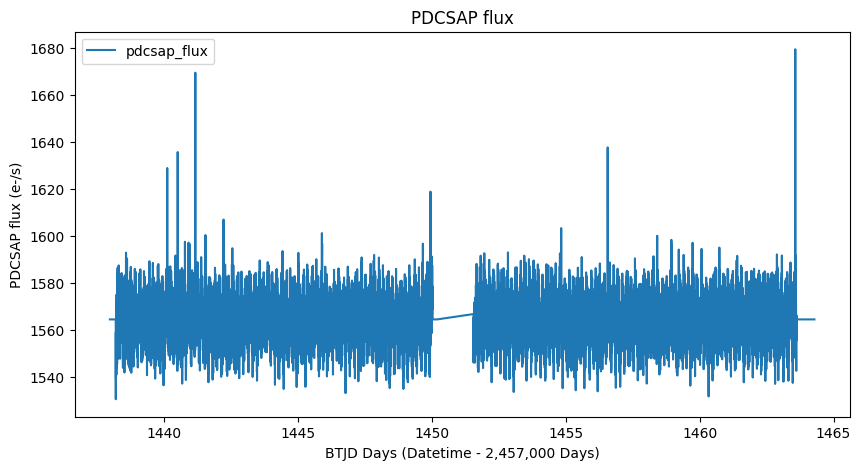

In [198]:
## Holistic plot of the time series
# Plot
pdcsap.plot(y = "pdcsap_flux", title = "PDCSAP flux", figsize = (10, 5))
plt.xlabel("BTJD Days (Datetime - 2,457,000 Days)")
plt.ylabel("PDCSAP flux (e-/s)")

# Flag outliers
###

plt.show()

The date range of 1438-1442 looks interesting, let's zoom in for a better look.

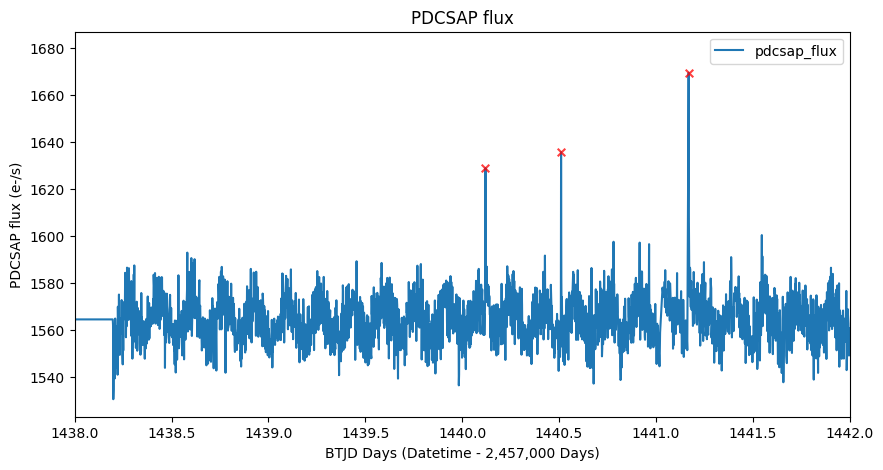

In [199]:
## Zoom in

# Plot
pdcsap.query("1438 <= index <= 1442").plot(y = "pdcsap_flux", title = "PDCSAP flux", figsize = (10, 5))
plt.xlabel("BTJD Days (Datetime - 2,457,000 Days)")
plt.ylabel("PDCSAP flux (e-/s)")
plt.xlim([1438, 1442])

# Flag outliers
num_devs = 5
outliers = (pdcsap["pdcsap_flux"] < mean_val - num_devs * std_val) | (pdcsap["pdcsap_flux"] > mean_val + num_devs * std_val)
plt.scatter(x = pdcsap.index[outliers], y = pdcsap["pdcsap_flux"][outliers], color='red', s=30, zorder=3, marker="x", alpha = 0.75)

plt.show()

In [ ]:
#pdcsap[(pdcsap["time"] <= 1442) & (pdcsap["time"] >= 1438)]
#pdcsap.query("1438 <= index <= 1442")
#pdcsap.index

### Comments

--

## Autocorrelation and Frequency

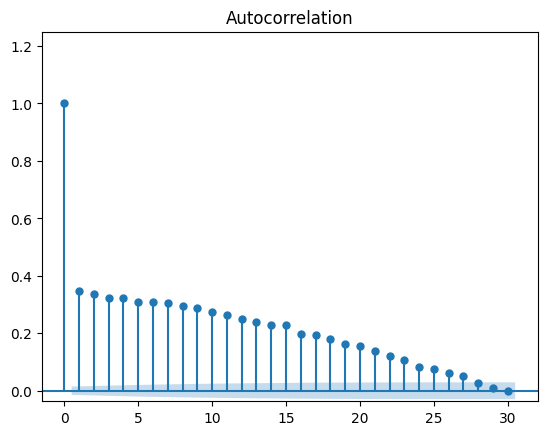

In [51]:
# Autocorrelation
import statsmodels.api as sm
#pd.plotting.autocorrelation_plot()
sm.graphics.tsa.plot_acf(pdcsap['pdcsap_flux'], lags = 30, auto_ylims=True)

plt.show()

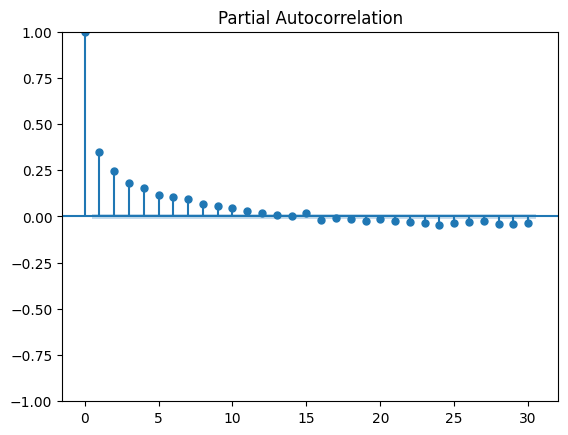

In [55]:
## Partial Autocorrelation
sm.graphics.tsa.plot_pacf(pdcsap['pdcsap_flux'], lags = 30, method = 'ywm')

plt.show()

### Comments

--

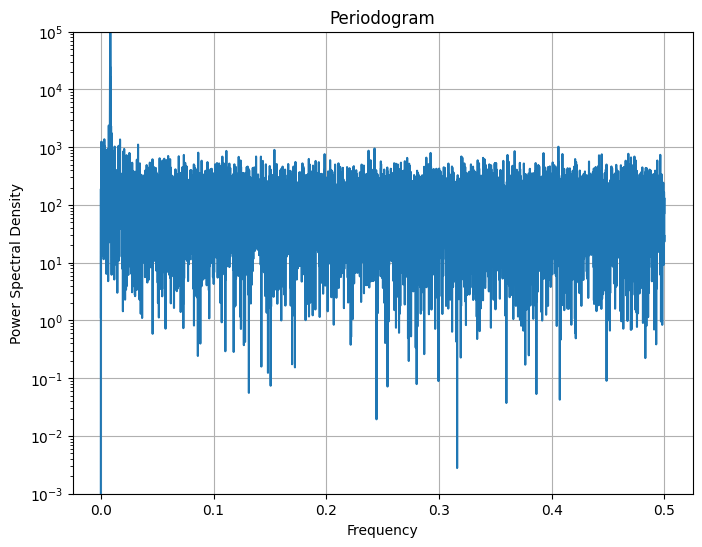

In [57]:
## Periodogram
from scipy.signal import periodogram
freq, power_spectral_density = periodogram(pdcsap['pdcsap_flux'], fs=1)

# Plot
plt.figure(figsize=(8, 6))
plt.semilogy(freq, power_spectral_density)  # Log scale for better visualization
plt.title("Periodogram")
plt.xlabel("Frequency")
plt.ylabel("Power Spectral Density")
plt.grid(True)
plt.ylim([10**(-3), 10**5])

plt.show()

### Comments

--